In [ ]:
#Install modules not available already in google colab
!pip install transformers
!pip install torch
#install older version of seqeval as current does not support f1 scores due to known bug
!pip install 'seqeval==0.0.12'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 56.5 MB/s 
     |████████████████████████████████| 163 kB 92.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7435 sha256=745c8f7b1d034885377d3bfbb9351b7ef8e0eeaaf8e3dfd71afa429205a9fa4f
  Stored in directory: /root/.cache/pip/wheels/dc/cc/62/a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval


In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

87G


In [ ]:
#data manipulation
import pandas as pd
import numpy as np

#Model development
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

#Data analysis
from seqeval.metrics import f1_score, accuracy_score

#charting
import matplotlib.pyplot as plt
import seaborn as sns

print(f'Tranformers Version: {transformers.__version__}')
print(f'Torch version:  {torch.__version__}')

Tranformers Version: 4.22.2
Torch version:  1.12.1+cu113


In [ ]:
# Read dataset into pandas dataframe and preprocess
data = pd.read_csv("dataset.csv", encoding="latin1")
data.head()

,Unnamed: 0,0,1,2
0,0,prescription_duration,mometasone furoate has been prescribed for 24 ...,"[('mometasone', 'B-Drug'), ('furoate', 'I-Drug..."
1,1,inadequate_monitoring,brinzolamide and testosterone propionate requi...,"[('brinzolamide', 'B-Drug'), ('and', 'o'), ('t..."
2,2,medication_overprescribing,patient sturggling to take medications stop en...,"[('patient', 'o'), ('sturggling', 'o'), ('to',..."
3,3,known_allergy,mr bud has a known allergy to perphenazine ho...,"[('mr ', 'o'), ('bud', 'o'), ('has', 'o'), ('a..."
4,4,reduce_doses,prazosin hydrochloride was reduced from 25mg t...,"[('prazosin', 'B-Drug'), ('hydrochloride', 'I-..."


In [ ]:
data.rename(columns={'0':'Type','1':'Text','2':'Tags'},inplace=True)
#replace known error in dataset
data['Tags'] = data['Tags'].apply(lambda x: x.replace('I-Ation','I-Action'))
data.head()

,Unnamed: 0,Type,Text,Tags
0,0,prescription_duration,mometasone furoate has been prescribed for 24 ...,"[('mometasone', 'B-Drug'), ('furoate', 'I-Drug..."
1,1,inadequate_monitoring,brinzolamide and testosterone propionate requi...,"[('brinzolamide', 'B-Drug'), ('and', 'o'), ('t..."
2,2,medication_overprescribing,patient sturggling to take medications stop en...,"[('patient', 'o'), ('sturggling', 'o'), ('to',..."
3,3,known_allergy,mr bud has a known allergy to perphenazine ho...,"[('mr ', 'o'), ('bud', 'o'), ('has', 'o'), ('a..."
4,4,reduce_doses,prazosin hydrochloride was reduced from 25mg t...,"[('prazosin', 'B-Drug'), ('hydrochloride', 'I-..."


In [ ]:
from ast import literal_eval

sentences = []
labels = []

def getSentences(x):
  # ensure tags is recongised as array and not str
  x = literal_eval(x)

  sentArr = []
  tagArr = []

  for i in x:
    sentArr.append(i[0])
    tagArr.append(i[1])

  sentences.append(sentArr)
  labels.append(tagArr)

data['Tags'].apply(lambda x: getSentences(x))

0        None
1        None
2        None
3        None
4        None
         ... 
67995    None
67996    None
67997    None
67998    None
67999    None
Name: Tags, Length: 68000, dtype: object

In [ ]:
print(sentences[0])
print(labels[0])

['mometasone', 'furoate', 'has', 'been', 'prescribed', 'for', '24', 'days', 'this', 'is', 'longer', 'than', 'normal', 'please', 'review', 'need', 'to', 'suspend']
['B-Drug', 'I-Drug', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'B-Action']


In [ ]:
#Get individual Tags and add PAD value
tag_values = list(set([i for tag in labels for i in tag]))
tag_values.append("PAD")
print(tag_values)

['I-Freq', 'B-Freq', 'I-Dose', 'o', 'B-Dose', 'B-Drug', 'B-Route', 'B-Action', 'I-Action', 'I-Drug', 'I-Route', 'PAD']


In [ ]:
#Create tag index
tag2idx = {tag: index for index, tag in enumerate(tag_values)}
tag2idx

{'I-Freq': 0,
 'B-Freq': 1,
 'I-Dose': 2,
 'o': 3,
 'B-Dose': 4,
 'B-Drug': 5,
 'B-Route': 6,
 'B-Action': 7,
 'I-Action': 8,
 'I-Drug': 9,
 'I-Route': 10,
 'PAD': 11}

In [ ]:
#find longest sentence in data
data['sent_length'] = data['Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
# set maximum length to longest sentence

longestSentence = data['sent_length'].max()
MAX_LEN = longestSentence
BATCH_SIZE = 32

print(f'Max length has been set to {MAX_LEN}')

Max length has been set to 87


In [ ]:
#Check if GPUS available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(device)

cuda


In [ ]:
#import tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def tokenize_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        # Tokenize the word
        tokenized_word = tokenizer.tokenize(word)

        # Count number of subwords each word has been broken down into
        noSubwords = len(tokenized_word)

        # Add the word to list and add extra labels for tokenised word
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * noSubwords)

    return tokenized_sentence, labels

tokenized_texts_and_labels = [
    tokenize_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
print(tokenized_texts_and_labels[0][0])
print(tokenized_texts_and_labels[0][1])

['mom', '##eta', '##son', '##e', 'fur', '##oat', '##e', 'has', 'been', 'prescribed', 'for', '24', 'days', 'this', 'is', 'longer', 'than', 'normal', 'please', 'review', 'need', 'to', 'su', '##sp', '##end']
['B-Drug', 'B-Drug', 'B-Drug', 'B-Drug', 'I-Drug', 'I-Drug', 'I-Drug', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'B-Action', 'B-Action', 'B-Action']


In [ ]:
#Create array of all text that has been tokenised
tokenized_texts = [token[0] for token in tokenized_texts_and_labels]
#Create labels
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]


In [ ]:
#convert tokens to texts to Ids and add padding
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],maxlen=MAX_LEN, dtype="long", value=0.0,truncating="post", padding="post")
input_ids[0]

array([ 4113, 12405,  2142,  1162,  9015, 20534,  1162,  1144,  1151,
       17421,  1111,  1572,  1552,  1142,  1110,  2039,  1190,  2999,
        4268,  3189,  1444,  1106, 28117, 20080,  6696,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])

In [ ]:
#convert tags to ids and add padding
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",dtype="long", truncating="post")
tags[0]

array([ 5,  5,  5,  5,  9,  9,  9,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  7,  7,  7, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11])

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.2)

In [ ]:
tr_inputs = torch.tensor(tr_inputs).type(torch.LongTensor)
val_inputs = torch.tensor(val_inputs).type(torch.LongTensor)
tr_tags = torch.tensor(tr_tags).type(torch.LongTensor)
val_tags = torch.tensor(val_tags).type(torch.LongTensor)
tr_masks = torch.tensor(tr_masks).type(torch.LongTensor)
val_masks = torch.tensor(val_masks).type(torch.LongTensor)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
len(train_data)

54400

In [ ]:
#Define model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.cuda();

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,lr=3e-5,eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

predicted_data = []
valid_data = []
f1s = []

for _ in trange(epochs, desc="Epoch"):
    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)



    # Validation
    # Measure performance on validation set after each epoch

    model.eval()

    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # do not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))

    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    try:
      f1 = f1_score(pred_tags, valid_tags)
      print("Validation F1-Score: {}".format(f1))
      predicted_data.append(pred_tags)
      valid_data.append(valid_tags)
      f1s.append(f1)

    except:
      print('')
    print()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.026851938198858134
Validation loss: 0.001032902999457506
Validation Accuracy: 0.9994028498040204


Epoch:  20%|██        | 1/5 [08:52<35:31, 532.88s/it]

Validation F1-Score: 0.9981681093311172

Average train loss: 0.0010378893020285486
Validation loss: 0.0008998380190314492
Validation Accuracy: 0.9995383732527533


Epoch:  40%|████      | 2/5 [17:42<26:32, 530.79s/it]

Validation F1-Score: 0.9987983103515246

Average train loss: 0.00044945881521711914
Validation loss: 0.000579186522449805
Validation Accuracy: 0.9997564813030579


Epoch:  60%|██████    | 3/5 [26:31<17:40, 530.08s/it]

Validation F1-Score: 0.9993052163386418

Average train loss: 0.00024909575713536467
Validation loss: 0.0006852151833663811
Validation Accuracy: 0.9997268355486476


Epoch:  80%|████████  | 4/5 [35:21<08:49, 529.89s/it]

Validation F1-Score: 0.9992809531466643

Average train loss: 6.579994663565338e-05
Validation loss: 0.0005688893827626838
Validation Accuracy: 0.9997840095035818


Epoch: 100%|██████████| 5/5 [44:10<00:00, 530.09s/it]

Validation F1-Score: 0.999417482797539



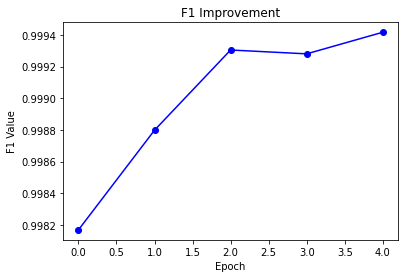

In [ ]:
labels = ['Epoch 1','Epoch 2','Epoch 3','Epoch 4','Epoch 5']

plt.plot(f1s, 'b-o', label=labels)
plt.title("F1 Improvement")
plt.xlabel("Epoch")
plt.ylabel("F1 Value")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(predicted_data[0],valid_data[0])

array([[ 24136,      0,      1,      0,      0,      1,      0,      0,
             0,      0,      3],
       [     0,  16280,      0,      0,      0,      0,      7,      2,
             0,      0,      0],
       [     5,      0,  85881,      0,      0,      2,      0,     63,
             0,      0,     47],
       [     0,      0,      0,   1775,      0,      0,      0,      1,
             3,      0,      6],
       [     0,      0,      0,      0,   1608,      0,      0,      0,
             0,      0,      2],
       [     0,      0,      0,      0,      0,  12747,      0,      0,
             0,      0,      0],
       [     0,      2,      0,      0,      0,      0,    361,      5,
             0,      0,      0],
       [     0,      0,     27,      1,      0,      0,      0,  47878,
             0,      0,     16],
       [     0,      0,      0,      0,      0,      0,      0,      0,
          1336,      0,      1],
       [     0,      0,      0,      0,      0,      0,

In [ ]:
predicted_series = pd.Series(predicted_data[0], name='Actual')
valid_series = pd.Series(valid_data[0], name='Predicted')
df_confusionMatrix = pd.crosstab(predicted_series,valid_series)
df_confusionMatrix

Predicted,B-Action,B-Dose,B-Drug,B-Freq,B-Route,I-Action,I-Dose,I-Drug,I-Freq,I-Route,o
Actual,,,,,,,,,,,
B-Action,24136,0,1,0,0,1,0,0,0,0,3
B-Dose,0,16280,0,0,0,0,7,2,0,0,0
B-Drug,5,0,85881,0,0,2,0,63,0,0,47
B-Freq,0,0,0,1775,0,0,0,1,3,0,6
B-Route,0,0,0,0,1608,0,0,0,0,0,2
I-Action,0,0,0,0,0,12747,0,0,0,0,0
I-Dose,0,2,0,0,0,0,361,5,0,0,0
I-Drug,0,0,27,1,0,0,0,47878,0,0,16
I-Freq,0,0,0,0,0,0,0,0,1336,0,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


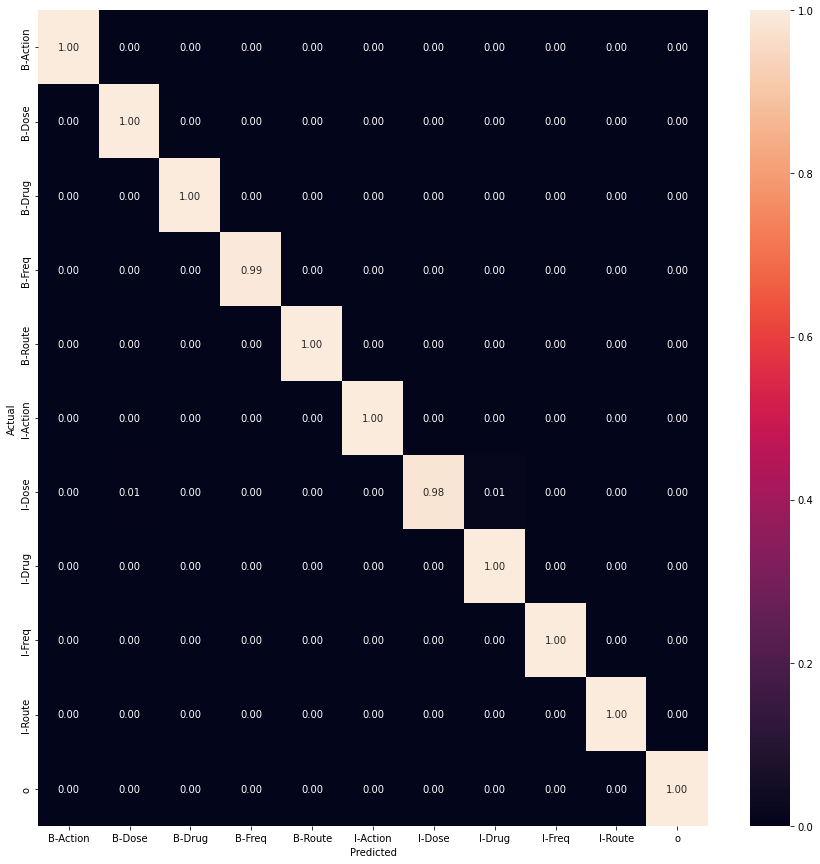

In [ ]:
# Normalise
from matplotlib.pyplot import figure

cmn = df_confusionMatrix.astype('float') / df_confusionMatrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

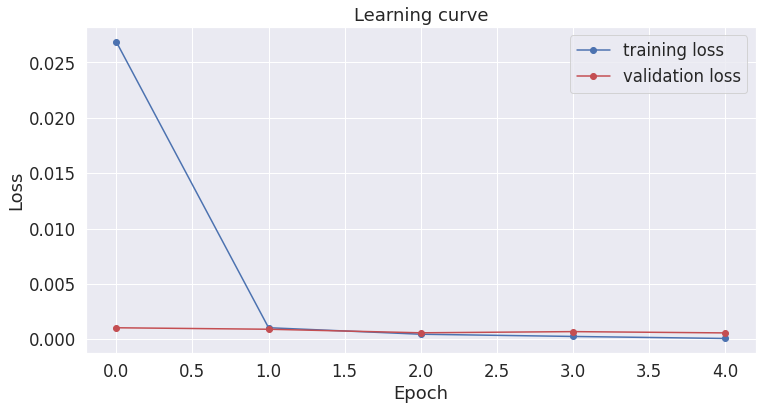

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
test_sentences = ["""""","""THis patients states they are taking a drug called acitaminophen this isn't available in this country it is actually known as paracetamol in the united kingdom""","""Biisoprololl Is spelt incorrectly. Should be spelled as bisoprolol and also its dose needs to be increased as it is incorrect""","""The patient last visited their GP in may where they were told to stop taking bisoprolol amitriptyline ramipril and digoxin Can these medications be reviewed and discontinued from the inpatient chart please thank you ben logan pharmacist on ward 3d""","""The drugs included in this note are made up and do not exist in the data set provided randomperidol or madeupdulafungin are two fake drugs that do have a similar strucutre to other drug names""","""Bisoprolol has been prescribed for this patient whoever it interacts with amlodipine. Can it be discontinued
""","""Amitriptyline is indicated for neuropathic pain review need to start""","""Adcal has been prescribed in error review need to stop""","""Rocuronium is not indicted for this patient please discontinue""","""alfentanil dose needs increasing to 500mg""","""trastuzumab is an opiod and shouldn't be prescribed for a patient with a eGFR less than 50 please discontinue""","""megatronoprolol interacts with optimusprimulin please discontinue both or start an alternative""","""review need to prescribe Keppra""","""Drs jobs please stop prescription for metoprolol""", """Plazomicin is a drug which did not make it to market and therefore does not exist within the dataset""","""Doses often come fairly straightforward. For instance the dose of trimethoprim is often 200mg. Some drugs such as chlorhexidine may be dosed on their strength e.g. 0.2%. co-trimoxazole although it contains trimethoprim is often dosed on adjusted body weight at 30mg/kg four times a day vials of co-timoxazole also known as septrin come in a strength of 480mg/5ml"""]

In [ ]:
tested_sentences = []
def testSentences(test_sentence):
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  with torch.no_grad():
      output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)

  for token, label in zip(new_tokens, new_labels):
    tested_sentences.append((token,label))

for i in test_sentences:
  testSentences(i)

In [ ]:
from IPython.core.display import display, HTML



testedHTML = '<h1> Test Sentences </h1>'
for i in tested_sentences:
  if i[0] != '[CLS]' and i[0] != '[SEP]':
    if i[1] != 'o':
      testedHTML += f'<span style="background-color: #FF6663; line-height:30px; display:inline-block;"> <b>{i[0]} ({i[1]})</b></span> '
    else:
      testedHTML += f'<span> {i[0]} </span>'
  if i[0] == '[SEP]':
    testedHTML += '<br/><br/>'

display(HTML(testedHTML))


In [ ]:
torch.save(model.state_dict(), 'model_weights2.pt')